In [381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [382]:
df = pd.read_csv('heart.csv')

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [383]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [384]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [385]:
df.shape

(918, 12)

<Axes: xlabel='Sex', ylabel='count'>

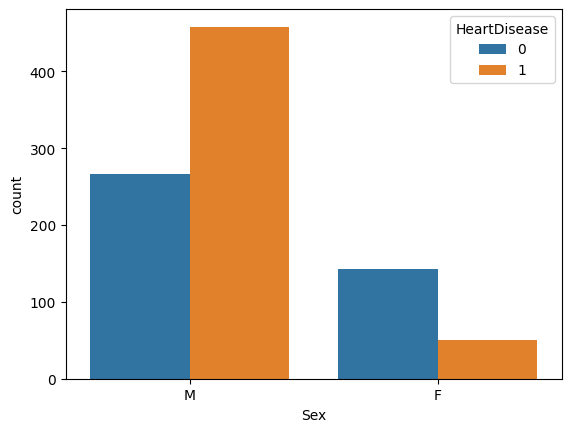

In [386]:
sns.countplot(data=df, x='Sex', hue='HeartDisease')

In [387]:
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [388]:
encoder = OneHotEncoder(sparse_output=False) 
encoded_data = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_data, columns = encoder.get_feature_names_out(categorical_columns))

In [389]:
df = df.drop(categorical_columns, axis=1)
df = pd.concat([df, encoded_df], axis=1)

In [390]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,1.0,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,150,195,0,122,0.0,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [391]:
X = [x for x in df.columns if x not in 'HeartDisease']

In [392]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df['HeartDisease'], test_size = 0.2, random_state=12)

In [393]:
X_train.shape

(734, 20)

# Decision Tree

**Hyperparameters**:
Conditions to stop splitting
1. min_samples_split: Purity Threshold. Minimum number of samples of a particular class required to split. Lower values leads to deeper trees and may result in overfitting. Higher values leads to shallower trees and may lead to underfitting.
2. max_depth: Maximum depth of the treee. Governs when to stop splitting in order not to exceed the maximum depth.

In [394]:
min_samples_list = [2,4,5,8,15,20,50,100,250,500]
max_depth_list = [1,2,4,5,6,8,10,15,30, None]

In [395]:
training_accuracy = []
testing_accuracy = []

In [396]:
for min_samples_split in min_samples_list:
    model = tree.DecisionTreeClassifier(min_samples_split = min_samples_split, random_state = 10).fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    acc_train = accuracy_score(pred_train, y_train)
    acc_test = accuracy_score(pred_test, y_test)
    training_accuracy.append(acc_train)
    testing_accuracy.append(acc_test)

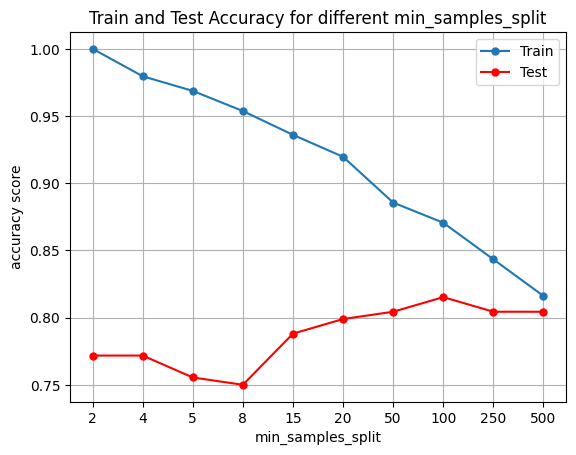

In [397]:
plt.xticks(ticks=range(len(min_samples_list)), labels = min_samples_list)
plt.plot(training_accuracy,marker = 'o',markersize = 5)
plt.plot(testing_accuracy,color='red', marker = 'o',markersize = 5)
plt.xlabel('min_samples_split')
plt.ylabel('accuracy score')
plt.title('Train and Test Accuracy for different min_samples_split')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

In [398]:
training_accuracy = []
testing_accuracy = []

In [399]:
for max_depth in max_depth_list:
    model = tree.DecisionTreeClassifier(max_depth = max_depth, random_state = 10).fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    acc_train = accuracy_score(pred_train, y_train)
    acc_test = accuracy_score(pred_test, y_test)
    training_accuracy.append(acc_train)
    testing_accuracy.append(acc_test)

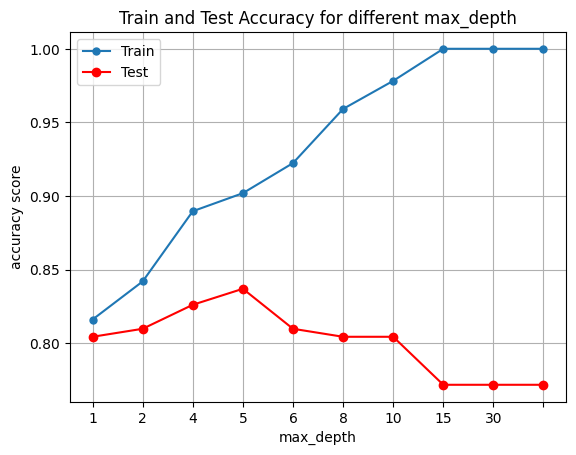

In [400]:
plt.xticks(ticks=range(len(max_depth_list)), labels = max_depth_list)
plt.plot(training_accuracy,marker = 'o',markersize=5)
plt.plot(testing_accuracy,color='red', marker = 'o')
plt.xlabel('max_depth')
plt.ylabel('accuracy score')
plt.title('Train and Test Accuracy for different max_depth')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

Fitting a decision tree with the parameters giving the highest test accuracy:

- min_samples_split: 100
- max_depth: 55

In [401]:
decision_tree_model = tree.DecisionTreeClassifier(min_samples_split=100, 
                                                  max_depth=5, 
                                                  random_state=10)
decision_tree_model.fit(X_train, y_train)
ypred_train = decision_tree_model.predict(X_train)
ypred_test = decision_tree_model.predict(X_test)
accuracy_train = accuracy_score(ypred_train, y_train)
accuracy_test = accuracy_score(ypred_test, y_test)

In [402]:
print("Decision Tree Classifier")
print(f"Training Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

Decision Tree Classifier
Training Accuracy: 0.8705722070844687
Test Accuracy: 0.8206521739130435


**Using GridSearchCV**

In [403]:
decision_tree_model2 = tree.DecisionTreeClassifier(random_state=10)

In [404]:
param_grid = {
    'min_samples_split' : [2,4,5,8,15,20,50,100,250,500],
    'max_depth' : [1,2,4,5,6,8,10,15,30, None]
}

In [405]:
grid_search = GridSearchCV(decision_tree_model2, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

{'max_depth': 4, 'min_samples_split': 20}


In [406]:
best_model = grid_search.best_estimator_
ypred_train = best_model.predict(X_train)
ypred_test = best_model.predict(X_test)
accuracy_train = accuracy_score(ypred_train, y_train)
accuracy_test = accuracy_score(ypred_test, y_test)
print(f"Training Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

Training Accuracy: 0.885558583106267
Test Accuracy: 0.8315217391304348


# Random Forest Classifier

n_estimators : Number of Decision Trees in the model. 

 

We use a subset of features and a subset of training set to train each tree.

In [407]:
min_samples_list = [2,4,5,8,15,20,50,100,250,500]
max_depth_list = [1,2,4,5,6,8,10,15,30, None]
n_estimators_list = [1,10,20,50,100,200,400,500]

In [408]:
training_accuracy = []
testing_accuracy = []

In [409]:
for min_samples in min_samples_list:
    model = RandomForestClassifier(min_samples_split = min_samples, random_state=10).fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    acc_train = accuracy_score(pred_train, y_train)
    acc_test = accuracy_score(pred_test, y_test)
    training_accuracy.append(acc_train)
    testing_accuracy.append(acc_test)

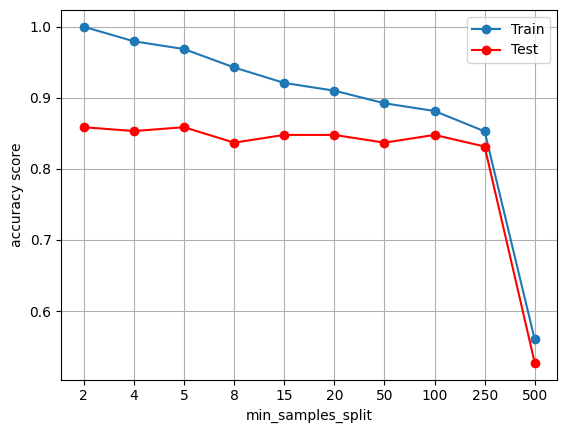

In [410]:
plt.plot(training_accuracy, marker='o')
plt.plot(testing_accuracy,color='red', marker='o')
plt.xticks(ticks=range(len(min_samples_list)), labels=min_samples_list)
plt.xlabel('min_samples_split')
plt.ylabel('accuracy score')
plt.grid()
plt.legend(['Train','Test'])

In [411]:
training_accuracy = []
testing_accuracy = []

In [412]:
for max_depth in max_depth_list:
    model = RandomForestClassifier(max_depth = max_depth, random_state=10).fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    acc_train = accuracy_score(pred_train, y_train)
    acc_test = accuracy_score(pred_test, y_test)
    training_accuracy.append(acc_train)
    testing_accuracy.append(acc_test)

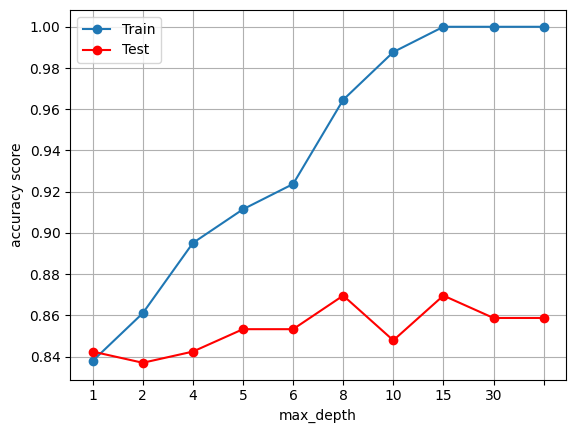

In [413]:
plt.plot(training_accuracy, marker='o')
plt.plot(testing_accuracy,color='red', marker='o')
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.xlabel('max_depth')
plt.ylabel('accuracy score')
plt.grid()
plt.legend(['Train','Test'])

In [414]:
training_accuracy = []
testing_accuracy = []

In [415]:
for n_estimators in n_estimators_list:
    model = RandomForestClassifier(n_estimators = n_estimators, random_state=10).fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    acc_train = accuracy_score(pred_train, y_train)
    acc_test = accuracy_score(pred_test, y_test)
    training_accuracy.append(acc_train)
    testing_accuracy.append(acc_test)

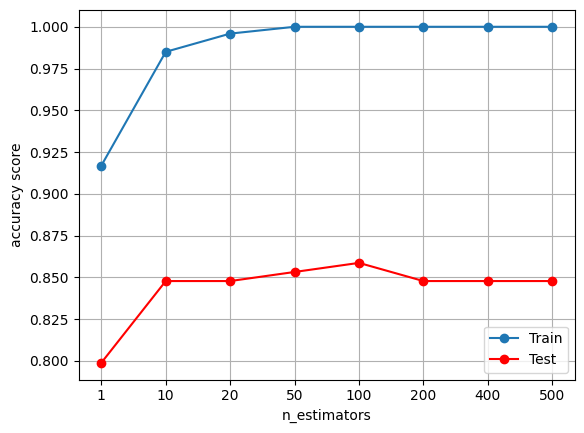

In [416]:
plt.plot(training_accuracy, marker='o')
plt.plot(testing_accuracy, color='red', marker='o')
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)
plt.xlabel('n_estimators')
plt.ylabel('accuracy score')
plt.grid()
plt.legend(['Train','Test'])

Fitting a random forest with the parameters giving the highest test accuracy:

- n_estimators: 100
- min_samples_split: 2
- max_depth: 15

In [417]:
random_forest_model = RandomForestClassifier(n_estimators=100, 
                                             min_samples_split=2, 
                                             max_depth=15, 
                                             random_state=10).fit(X_train, y_train)

ypred_train = random_forest_model.predict(X_train)
ypred_test = random_forest_model.predict(X_test)
accuracy_train = accuracy_score(ypred_train, y_train)
accuracy_test = accuracy_score(ypred_test, y_test)

In [418]:
print("Random Forest Classifier")
print(f"Training Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

Random Forest Classifier
Training Accuracy: 1.0
Test Accuracy: 0.8695652173913043


# XG Boost Classifier

In [419]:
xgb_model = XGBClassifier(n_estimators=500, max_depth=10, random_state=10)
xgb_model.fit(X_train, y_train)
ypred_train = xgb_model.predict(X_train)
ypred_test = xgb_model.predict(X_test)
accuracy_train = accuracy_score(ypred_train, y_train)
accuracy_test = accuracy_score(ypred_test, y_test)

In [420]:
print("XGB Classifier")
print(f"Training Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")

XGB Classifier
Training Accuracy: 1.0
Test Accuracy: 0.8695652173913043
